# Preparing our data for use in Mobie 

#### Part 1: We need to stitch the raw image tiles together (N=962) to compose the entire embryo slice.

#### Part 2: We need to position and stitch the segmentation masks (N=371,012) to overly them on top of the entire embryo slice.

In [31]:
import os 
from glob import glob
import tifffile
import zarr 
import matplotlib.pyplot as plt
from tqdm import tqdm

In [32]:
# Setting directories
root_dir = '/mnt/efs/shared_data/instance_no_gt/20230830_TIF_cellpose_test/'
cellpose_pred_tiles_files = sorted(glob(os.path.join(root_dir, 'masks', '*.tif')))
raw_tiles = sorted(glob(os.path.join(root_dir, 'raw_files', '*.tif')))

### Stitching the raw image tiles together

In [33]:
image_test = tifffile.imread(raw_tiles[599])
tile_shape = image_test.shape

# getting the full shape 
tiles_y = 26
tiles_x = 37
tiles_x * tiles_y == len(raw_tiles) # True !

# computing big shape
big_shape = (tiles_x * image_test.shape[0], tiles_y * image_test.shape[1])
print(big_shape) # 37440, 71040 pixel image; why we need .zarr


(53280, 49920)


In [37]:
# define PATH
path_to_stitch = '/mnt/efs/shared_data/instance_no_gt/big_zarr/stitched_image_plane_6.zarr'

# create new .zarr 
zarrfile = zarr.open(path_to_stitch, mode = 'a')
zarr_image = zarrfile.require_dataset('image', shape = big_shape, chunks = image_test.shape, dtype = image_test.dtype)

In [38]:
# Defining sub-structures of the .zarr file 

# First, need to arrange the tiles: 

for idx, image in tqdm(enumerate(raw_tiles), total = len(raw_tiles), disable=False): 
    tile_index_y = idx // tiles_y
    tile_index_x = idx % tiles_y

    image = tifffile.imread(image)
    
    # translate tile indices to actual coordinate
    index_y = tile_index_y * tile_shape[0]
    index_x = tile_index_x * tile_shape[1]
    # print(idx, ":", tile_index_y, tile_index_x, ":", index_y, index_x)
    # continue
    
    # time to write to .zarr
    zarr_image[index_y:(image.shape[0]+index_y),index_x:(image.shape[1]+index_x)] = image 


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 962/962 [01:47<00:00,  8.96it/s]


In [39]:
# looking at it via napari
import napari 
image = zarrfile['image']
napari.view_image(image)
napari.run()

/home/evan/conda/envs/06_instance_segmentation/lib/python3.8/site-packages/napari/_vispy/layers/image.py:274: UserWarning: data shape (53280, 49920) exceeds GL_MAX_TEXTURE_SIZE 8192 in at least one axis and will be downsampled. Rendering is currently in 2D mode.
  warnings.warn(
/home/evan/conda/envs/06_instance_segmentation/lib/python3.8/site-packages/napari/_vispy/layers/image.py:274: UserWarning: data shape (53280, 49920) exceeds GL_MAX_TEXTURE_SIZE 8192 in at least one axis and will be downsampled. Rendering is currently in 2D mode.
  warnings.warn(


### Positioning and stitching the segmentation masks

#### We will use the cellpose prediction generated by Bruno.

In [23]:
# we will use this PATH to extract the cellpose prediction (N=962 tiles)
cellpose_pred_tiles = sorted(glob(os.path.join(root_dir, 'masks', '*.tif')))

(1440, 1920)


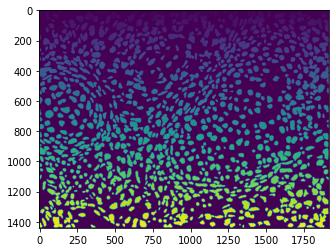

In [29]:
pred_mask_test = tifffile.imread(cellpose_pred_tiles[599])
print(pred_mask_test.shape) # dim is (1440,1920)
plt.imshow(pred_mask_test)

In [ ]:
# Same as before: 
# getting the full shape 
tiles_y = 26
tiles_x = 37
tiles_x * tiles_y == len(raw_tiles) # True !

# computing big shape
big_shape = (tiles_x * image_test.shape[0], tiles_y * image_test.shape[1])
print(big_shape) # 37440, 71040 pixel image; why we need .zarr

In [ ]:
# define PATH
path_to_stitch_mask = '/mnt/efs/shared_data/instance_no_gt/big_zarr/stitched_predicted_masks_plane_6.zarr'

# create new .zarr 
zarrfile_mask = zarr.open(path_to_stitch_mask, mode = 'a')
zarr_mask = zarrfile_mask.create_dataset('image', shape = big_shape, chunks = image_test.shape, dtype = image_test.dtype)

In [ ]:
zarr_mask = zarrfile["image"]

In [ ]:
# Defining sub-structures of the .zarr file 

# First, need to arrange the tiles: 

for idx, image in tqdm(enumerate(cellpose_pred_tiles), total = len(cellpose_pred_tiles), disable=False): 
    tile_index_y = idx // tiles_y
    tile_index_x = idx % tiles_x 

    image = tifffile.imread(image)
    
    # translate tile indices to actual coordinate
    index_y = tile_index_y * tile_shape[0]
    index_x = tile_index_x * tile_shape[1]
    # print(idx, ":", tile_index_y, tile_index_x, ":", index_y, index_x)
    # continue
    
    # time to write to .zarr
    zarr_mask[index_y:(image.shape[0]+index_y),index_x:(image.shape[1]+index_x)] = image

#### Alternative strategy: using the binarized independent cropped masks instead of cellpose predition.

/mnt/efs/shared_data/instance_no_gt/20230830_TIF_cellpose_test/cropped_masks/Tile00009_y1154_x1093.tif
(156, 156)


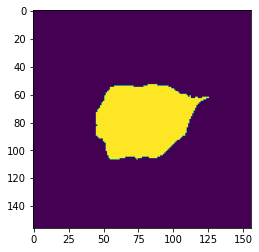

In [19]:
# Set the directory for cropped mask files:
cropped_mask_files = sorted(glob(os.path.join(root_dir, 'cropped_masks', '*.tif')))
print(cropped_mask_files[50]) 

# example name where tile is stored and coordinate of centroid:
# Tile00009_y1154_x1093.tif 

# example reading in and taking the shape:
test_mask = tifffile.imread(cropped_mask_files[50])
print(test_mask.shape) # 156, 156

# showing: 
plt.imshow(test_mask)